In [1]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
#sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
#import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
df=pd.read_csv('../input/train2016_withy.csv')

In [4]:
df=df.loc[np.random.permutation(df.index)]

In [5]:
q4idx=df[df.month>=10].index
len(q4idx)

8542

In [6]:
testx=df.drop(['parcelid','logerror','year','month'],axis=1)[(df.month>=10)]
testy=df['logerror'][(df.month>=10)]
testx.shape,testy.shape

((8542, 93), (8542,))

In [7]:
trainx=df.drop(['parcelid','logerror','year','month'],axis=1)[~(df.month>=10)]
trainy=df['logerror'][~(df.month>=10)]
trainx.shape,trainy.shape

((81733, 93), (81733,))

In [8]:
def init_xg():
    if 1:
        import sys
        xgpath='/home/spark/tmp/lib/'
        if xgpath not in sys.path:
            sys.path.insert(0, xgpath)
        import xgboost as xgb
        assert xgb.__file__.startswith(xgpath), xgb.__file__
        return xgb
    else:
        import xgboost as xgb
        return xgb
    

In [1]:
class Trainer():
    def __init__(self):
        self.xgb=init_xg()
    def train(self,trainx,trainy):
        if 0:
            ncol=int(trainx.shape[1]*0.6)
            self.cols=np.random.permutation(trainx.columns)[:ncol]
        else:
            self.cols=trainx.columns
        trainx=trainx[self.cols]
        from sklearn.model_selection import KFold
        from sklearn.utils import resample

        kf = KFold(n_splits=5,shuffle=True)
        models=[]
        for train_index, test_index  in kf.split(trainx):
            x_train, y_train, x_valid, y_valid = trainx.iloc[train_index],\
                trainy.iloc[train_index], trainx.iloc[test_index], trainy.iloc[test_index]
            if 1:
                idx=resample(range(len(x_train)))
                x_train=x_train.iloc[idx]
                y_train=y_train.iloc[idx]                
            models.append(self.train_once(x_train, y_train, x_valid, y_valid))
        self.models=models
        return self
    def train_once(self,x_train, y_train, x_valid, y_valid):
        xgb=self.xgb
        print('Building DMatrix...')
        d_train = xgb.DMatrix(x_train, label=y_train)
        d_valid = xgb.DMatrix(x_valid, label=y_valid)
        ymedian=np.median(y_train)
        print('Training ...')

        params = {}
        params['eta'] = 0.01
        params['objective'] = 'reg:smoothl1'
        #params['objective'] = 'reg:linear'
        params['subsample']=0.8
        params['colsample_bytree']=0.8
        params['eval_metric'] = 'mae'
        params['max_depth'] = 8
        params['silent'] = 1
        params['gamma'] = 2
        params['base_score'] = ymedian
        params['min_child_weight']=50
        params['tree_method']='hist'

        watchlist = [(d_train, 'train')] + [ (d_valid, 'valid')]
        clf = xgb.train(params, d_train, 300, watchlist, early_stopping_rounds=30, verbose_eval=10)
        return clf    
    def predict(self,x_test):
        x_test=x_test[self.cols]
        lst=[]
        d_test = self.xgb.DMatrix(x_test)
        for clf in self.models:
            p_test = clf.predict(d_test)
            lst.append(p_test)
        pred=reduce(lambda u,v:u+v, lst)/len(lst)
        return pred
    def score(self,x_test,y_test):
        pred=self.predict(x_test)
        return np.mean(np.abs(y_test-pred))

# spark

In [10]:
import findspark
findspark.init()

In [11]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',1)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','40G') 
conf.set('spark.executor.memory','5G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local[6]")

In [12]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

In [13]:
trainXY=sc.broadcast((trainx,trainy))
testXY=sc.broadcast((testx,testy))

In [2]:
def f():
    trainer=Trainer()
    trainer.train(trainXY.value[0],trainXY.value[1])
    return trainer.predict(testXY.value[0])

In [27]:
N=1000
%time pred=sc.parallelize(range(N)).map(lambda u: f()).reduce(lambda u,v: u+v)/N

CPU times: user 52.5 ms, sys: 25.4 ms, total: 77.9 ms
Wall time: 8min 56s


In [28]:
np.mean(np.abs(pred-testy))

0.06491966308027645

In [20]:
np.mean(np.abs(testy)),np.mean(np.abs(testy-np.median(testy)))

(0.06686067665652018, 0.06569923905408541)

# single 

In [302]:
trainer=Trainer()

In [328]:
trainer.train(trainx,trainy)

Building DMatrix...
Training ...
[0]	train-mae:0.068008	valid-mae:0.068799
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 30 rounds.
[10]	train-mae:0.067019	valid-mae:0.068415
[20]	train-mae:0.066466	valid-mae:0.06838
[30]	train-mae:0.066174	valid-mae:0.068373
[40]	train-mae:0.065828	valid-mae:0.068369
[50]	train-mae:0.065511	valid-mae:0.068388
Stopping. Best iteration:
[26]	train-mae:0.06629	valid-mae:0.068363

Building DMatrix...
Training ...
[0]	train-mae:0.068347	valid-mae:0.06727
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 30 rounds.
[10]	train-mae:0.067314	valid-mae:0.066956
[20]	train-mae:0.066924	valid-mae:0.066924
[30]	train-mae:0.066521	valid-mae:0.066889
[40]	train-mae:0.066164	valid-mae:0.066902
[50]	train-mae:0.06589	valid-mae:0.066923
Stopping. Best iteration:
[26]	train-mae:0.066653	valid-mae:0.066882

In [329]:
trainer.score(trainx,trainy)

0.06555350507366665

In [330]:
trainer.score(testx,testy)

0.0652844185157247

In [331]:
a=trainer.predict(testx)

In [332]:
#b=[]

In [333]:
b.append(a)
len(b)

4

In [334]:
c=reduce(lambda u,v: u+v,b)/len(b)

In [335]:
np.mean(np.abs(testy-c))

0.06497669222579197

In [336]:
pd.DataFrame(b).T.corr()

0         1         2         3
0  1.000000  0.732787  0.786621  0.797452
1  0.732787  1.000000  0.839678  0.699231
2  0.786621  0.839678  1.000000  0.741838
3  0.797452  0.699231  0.741838  1.000000

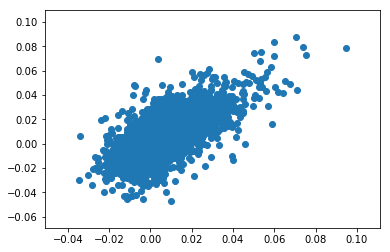

In [338]:
plt.scatter(b[3],b[1])

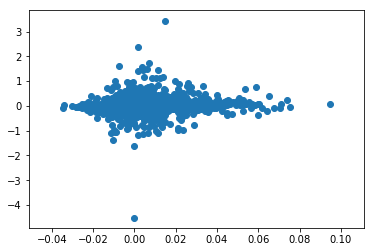

In [339]:
plt.scatter(b[3],testy)

In [298]:
pd.DataFrame(b).T.corr()

0         1         2         3
0  1.000000  0.949265  0.948688  0.948032
1  0.949265  1.000000  0.948031  0.950016
2  0.948688  0.948031  1.000000  0.947557
3  0.948032  0.950016  0.947557  1.000000

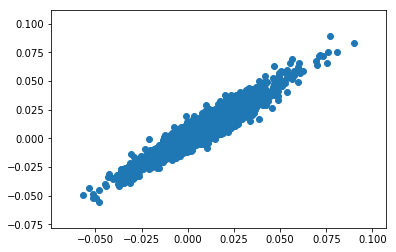

In [299]:
plt.scatter(b[0],b[1])

In [216]:
pd.DataFrame(b).T.corr()

0         1         2         3         4         5         6   \
0   1.000000  0.723784  0.740600  0.729777  0.839388  0.748381  0.788983   
1   0.723784  1.000000  0.579704  0.674970  0.812901  0.901630  0.875028   
2   0.740600  0.579704  1.000000  0.768755  0.740703  0.598582  0.609337   
3   0.729777  0.674970  0.768755  1.000000  0.739006  0.693321  0.733683   
4   0.839388  0.812901  0.740703  0.739006  1.000000  0.805833  0.779566   
5   0.748381  0.901630  0.598582  0.693321  0.805833  1.000000  0.863549   
6   0.788983  0.875028  0.609337  0.733683  0.779566  0.863549  1.000000   
7   0.890537  0.701723  0.777959  0.704043  0.829899  0.719600  0.751874   
8   0.690073  0.741164  0.610426  0.689327  0.658915  0.788110  0.770599   
9   0.757637  0.808429  0.621117  0.716779  0.724314  0.832820  0.866783   
10  0.841851  0.710583  0.758826  0.694506  0.828233  0.733055  0.735036   

          7         8         9         10  
0   0.890537  0.690073  0.757637  0.841851  
1   0.701723  0.741164  0.808429  0.710583  
2   0.777959  0.610426  0.621117  0.758826  
3   0.704043  0.689327  0.716779  0.694506  
4   0.829899  0.658915  0.724314  0.828233  
5   0.719600  0.788110  0.832820  0.733055  
6   0.751874  0.770599  0.866783  0.735036  
7   1.000000  0.640404  0.758102  0.891277  
8   0.640404  1.000000  0.770801  0.642120  
9   0.758102  0.770801  1.000000  0.741465  
10  0.891277  0.642120  0.741465  1.000000

In [142]:
np.mean(np.abs(testy-a))

0.06510454868547115

In [143]:
np.mean(np.abs(testy-b))

0.06520324329466395